Episode 1: Reward = 12.1
Episode 2: Reward = 29.52
Episode 3: Reward = 4.12
Episode 4: Reward = 1.0
Episode 5: Reward = 3.06
Episode 6: Reward = 6.300000000000001
Episode 7: Reward = 13.32
Episode 8: Reward = 19.720000000000002
Episode 9: Reward = 1.0
Episode 10: Reward = 1.0
Episode 11: Reward = 14.56
1/1 [==============================] - 0s 95ms/step
Episode 12: Reward = 41.92
1/1 [==============================] - 0s 24ms/step
Episode 13: Reward = 13.32
Episode 14: Reward = 3.06
Episode 15: Reward = 4.12
1/1 [==============================] - 0s 23ms/step
Episode 16: Reward = 34.02
Episode 17: Reward = 15.82
Episode 18: Reward = 5.2
Episode 19: Reward = 14.56
Episode 20: Reward = 2.02
1/1 [==============================] - 0s 24ms/step
Episode 21: Reward = 15.82
1/1 [==============================] - 0s 23ms/step
Episode 22: Reward = 8.56
1/1 [==============================] - 0s 22ms/step
Episode 23: Reward = 7.420000000000001
Episode 24: Reward = 2.02
Episode 25: Reward = 1.0
1/1

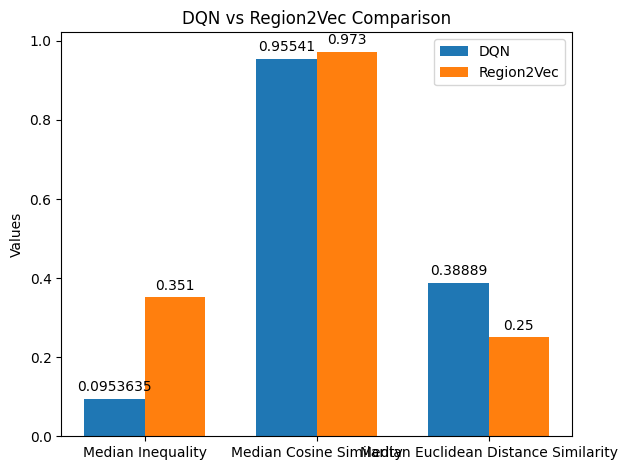

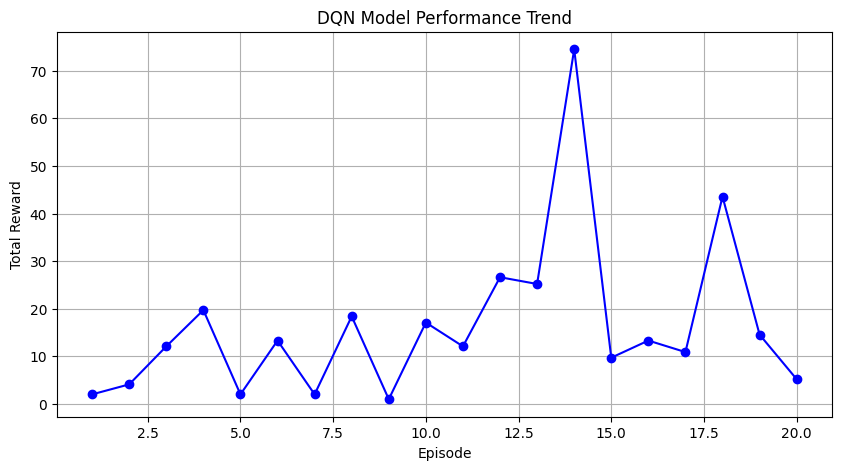

In [ ]:
!pip install matplotlib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
from numpy.linalg import norm


# Load and preprocess feature matrix
feature_matrix_path = "feature_matrix_f1.csv"
feature_matrix_df = pd.read_csv(feature_matrix_path, header=None)
scaler = MinMaxScaler()
scaled_feature_matrix = scaler.fit_transform(feature_matrix_df.iloc[:, 1:])
input_dim = scaled_feature_matrix.shape[1]
output_dim = 3

def create_dqn(input_dim, output_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim, activation='linear')
    ])
    return model

dqn_model = create_dqn(input_dim, output_dim)

# Training hyperparameters
num_episodes = 50
max_steps_per_episode = 50
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()
replay_buffer = []

def take_action(state_index, action, step, max_steps_per_episode):
    next_state_index = np.random.randint(0, scaled_feature_matrix.shape[0])
    next_state = scaled_feature_matrix[next_state_index]
    difference_threshold = 0.5
    difference = np.abs(state - next_state).mean()
    if difference > difference_threshold:
        reward = -1
    else:
        reward = 1
    reward_weight = 1 + (step / max_steps_per_episode)
    weighted_reward = reward * reward_weight
    done = np.random.rand() < 0.1
    return next_state, weighted_reward, done, next_state_index

for episode in range(num_episodes):
    state_index = np.random.randint(0, scaled_feature_matrix.shape[0])
    state = scaled_feature_matrix[state_index]
    episode_reward = 0
    for step in range(max_steps_per_episode):
        if np.random.rand() < epsilon:
            action = np.random.randint(output_dim)
        else:
            action = np.argmax(dqn_model.predict(state.reshape(1, -1))[0])
        next_state, reward, done, next_state_index = take_action(state_index, action, step, max_steps_per_episode)
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        state_index = next_state_index
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

# Evaluation Functions
def calculate_cosine_similarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return 0
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

def calculate_median_cosine_similarity(all_states):
    similarities = []
    for i in range(len(all_states)):
        for j in range(i + 1, len(all_states)):
            similarities.append(calculate_cosine_similarity(all_states[i], all_states[j]))
    return np.median(similarities) if similarities else 0

def calculate_median_euclidean_distance_similarity(all_states):
    distances = []
    for i in range(len(all_states)):
        for j in range(i + 1, len(all_states)):
            distances.append(euclidean(all_states[i], all_states[j]))
    return np.median(distances) if distances else 0

def calculate_median_inequality(all_states):
    variances = [np.var(state) for state in all_states]
    return np.median(variances) if variances else 0

import matplotlib.pyplot as plt

def evaluate_dqn_with_metrics(model, feature_matrix, num_episodes=50, max_steps_per_episode=50):
    total_rewards = []
    all_states = []

    for episode in range(num_episodes):
        state_index = np.random.randint(0, feature_matrix.shape[0])
        state = feature_matrix[state_index]
        episode_reward = 0

        for step in range(max_steps_per_episode):
            action = np.argmax(model.predict(state.reshape(1, -1))[0])
            next_state, reward, done, next_state_index = take_action(state_index, action, step, max_steps_per_episode)
            all_states.append(state)
            state = next_state
            state_index = next_state_index
            episode_reward += reward
            if done:
                break
        total_rewards.append(episode_reward)

    average_reward = np.mean(total_rewards)
    print(f"\n--- Evaluation Results ---")
    print(f"Average reward over {num_episodes} evaluation episodes: {average_reward}")

    # Store the metrics in variables
    dqn_median_inequality = calculate_median_inequality(all_states)
    dqn_median_cosine_similarity = calculate_median_cosine_similarity(all_states)
    dqn_median_euclidean_distance_similarity = calculate_median_euclidean_distance_similarity(all_states)

    print(f"Median Inequality: {dqn_median_inequality}")
    print(f"Median Cosine Similarity: {dqn_median_cosine_similarity}")
    print(f"Median Euclidean Distance Similarity: {dqn_median_euclidean_distance_similarity}")

    # Return metrics and total_rewards for plotting
    return dqn_median_inequality, dqn_median_cosine_similarity, dqn_median_euclidean_distance_similarity, total_rewards

# Run evaluation
dqn_results, total_rewards = evaluate_dqn_with_metrics(dqn_model, scaled_feature_matrix, num_episodes=20, max_steps_per_episode=50)[:3], evaluate_dqn_with_metrics(dqn_model, scaled_feature_matrix, num_episodes=20, max_steps_per_episode=50)[3]

print("\n--- Region2Vec Results ---")
print("Median Inequality: 0.351")
print("Median Cosine Similarity: 0.973")
print("Median Euclidean Distance Similarity: 0.250\n")
# Static "Region2Vec" results
region2vec_results = (0.351, 0.973, 0.250)

# Visualization
metrics = ['Median Inequality', 'Median Cosine Similarity', 'Median Euclidean Distance Similarity']
dqn_values = list(dqn_results)
region2vec_values = list(region2vec_results)

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dqn_values, width, label='DQN')
rects2 = ax.bar(x + width/2, region2vec_values, width, label='Region2Vec')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('DQN vs Region2Vec Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
print("\n")
# Trend Graph of DQN model's performance over episodes
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(total_rewards)+1), total_rewards, marker='o', linestyle='-', color='b')
plt.title('DQN Model Performance Trend')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()